# Pendulum Control with Classic Q-Learning

In [1]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# Function to render in notebook
def render_frame(env):
    frame = env.render()  # Returns the rendered frame as an RGB array
    plt.imshow(frame)
    plt.axis('off')  # Hide axis for better visualization
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

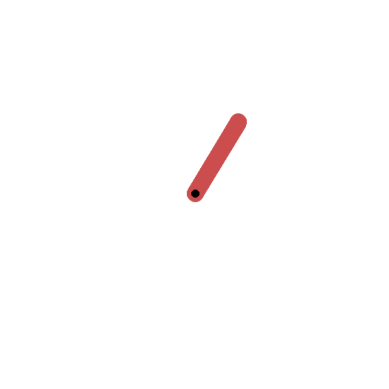

In [3]:
# Initialize the environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

render_frame(env)

### Goal 
- Apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

### Observation Space
- The observation is a ndarray with shape (3,) of continuous variables representing the x-y coordinates of the pendulum’s free end and its angular velocity.
    - x = cos(angle) [-1, 1]
    - y = sin(angle) [-1, 1]
    - z = theta, angular velocity [-8, 8]

### Action
- The torque applied to the end of the pendulum [-1, 1]

### Reward
- r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)
    - max is 0 when the pendulum is upright and no torque is applied

### End of episode
- After 200 timesteps

### Random Policy

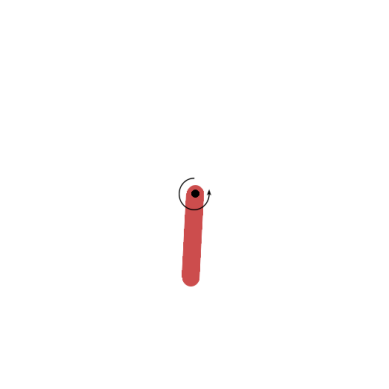

In [4]:
# visualize random policy

env = gym.make("Pendulum-v1", render_mode="rgb_array")
state, info = env.reset()

for _ in range(100):
    state, reward, done, _, info = env.step(env.action_space.sample())
    render_frame(env)

env.close()

In [5]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32), Box(-2.0, 2.0, (1,), float32))

### How can we apply Q-Learning?

A simple way to extend Q-Learning to complex scenarios is to discretize the observation and action spaces.

In [6]:
DISCRETE_ACTION_SPACE_SIZE = 17 # 17 actions
DISCRETE_OS_SIZE = np.array([21, 21, 65]) # 21 states for x, 21 for y, 65 for the angle

# create the windows
discrete_action_space_win_size = (env.action_space.high - env.action_space.low) / (DISCRETE_ACTION_SPACE_SIZE - 1)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / (DISCRETE_OS_SIZE - 1)

discrete_action_space_win_size, discrete_os_win_size

(array([0.25], dtype=float32), array([0.1 , 0.1 , 0.25]))

In [7]:
# mapping actions to the original action space
action_space = {
    i: [env.action_space.low[0] + (i * discrete_action_space_win_size[0])]
    for i in range(DISCRETE_ACTION_SPACE_SIZE)
}

# mapping original continuous space to the discretized one
def get_discrete_state(state):
    ds = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(ds.astype(np.int32))

In [8]:
state, info = env.reset()

print(f'Discretized space: {get_discrete_state(state)}')
print('First action', action_space[0])
print('Last action', action_space[16])

Discretized space: (0, 12, 32)
First action [-2.0]
Last action [2.0]


Now we can have a table of Q-Values that we can optimize.

In [9]:
q_table = np.random.uniform(low=-2, high=-0, size=(*DISCRETE_OS_SIZE, DISCRETE_ACTION_SPACE_SIZE))
q_table.shape

(21, 21, 65, 17)

We also need a epsilon decay function to balance exploration and exploitation during learning.

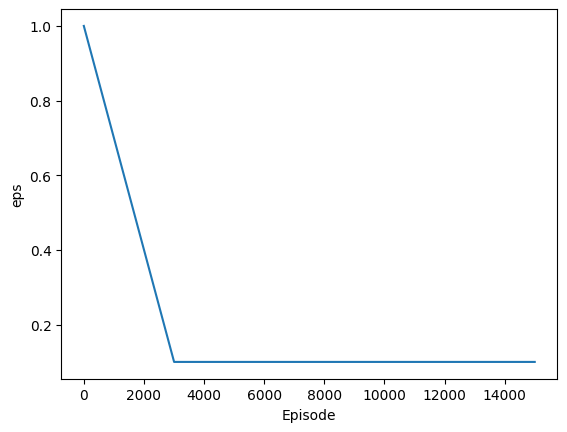

In [10]:
def get_eps(episode, min_eps=0.1, decay_fraction=0.2, total_episodes=15000):
    return max(min_eps, episode*(min_eps-1)/(total_episodes*decay_fraction)+1)

plt.plot([get_eps(x) for x in range(15000)])
plt.xlabel('Episode')
plt.ylabel('eps')
plt.show()

### Q Learning

![qlearning](img/qlearning.png)

In [13]:
def q_learning(env, gamma=0.95, eps_decay_fraction=0.1, learning_rate=0.1, num_episodes=150000):
    
    q_table = np.random.uniform(low=-2, high=-0, size=(*DISCRETE_OS_SIZE, DISCRETE_ACTION_SPACE_SIZE))
    
    # track the episode returns
    returns = []
    for episode in range(1,num_episodes+1):
        
        episode_return = 0
        state, info = env.reset()
        discrete_state = get_discrete_state(state)
        done = False
    
        while not done:
    
            eps = get_eps(episode, decay_fraction=eps_decay_fraction, total_episodes=num_episodes)
            
            if np.random.random() > eps:
                # Get action from Q table
                action = np.argmax(q_table[discrete_state])
            else:
                # Get random action
                action = np.random.randint(0, DISCRETE_ACTION_SPACE_SIZE)
    
            # apply the action to the environment
            torque = action_space[action]
            new_state, reward, done, truncated, _ = env.step(torque)
            done = done or truncated # same thing here
            episode_return += reward
            new_discrete_state = get_discrete_state(new_state)
            
            if not done:
    
                q = q_table[*discrete_state, action]
                next_q = np.max(q_table[new_discrete_state])
    
                # Update with the TD-Error
                new_q = (1 - learning_rate)*q + learning_rate * (reward + gamma * next_q)
    
                # update
                q_table[*discrete_state, action] = new_q
    
            discrete_state = new_discrete_state
    
        returns.append(episode_return)
    
        # log
        if episode % 10000 == 0:
            print(f'Episode {episode}, returns: {np.mean(returns[-10000:])}')

    return q_table, returns

In [14]:
%%time
q_table, returns = q_learning(env, num_episodes=150000)

Episode 10000, returns: -1189.5898228361918
Episode 20000, returns: -923.7606074293445
Episode 30000, returns: -702.2563386978474
Episode 40000, returns: -525.574657113411
Episode 50000, returns: -425.4105716628312
Episode 60000, returns: -356.4214458038922
Episode 70000, returns: -318.6317818249241
Episode 80000, returns: -278.2149863515209
Episode 90000, returns: -258.9686305559568
Episode 100000, returns: -243.8793985581637
Episode 110000, returns: -267.4728816832828
Episode 120000, returns: -235.49653700758876
Episode 130000, returns: -222.85840697042158
Episode 140000, returns: -219.35781915449627
Episode 150000, returns: -220.4670782480672
CPU times: user 7min 39s, sys: 7.28 s, total: 7min 46s
Wall time: 7min 41s


Text(0, 0.5, 'Returns')

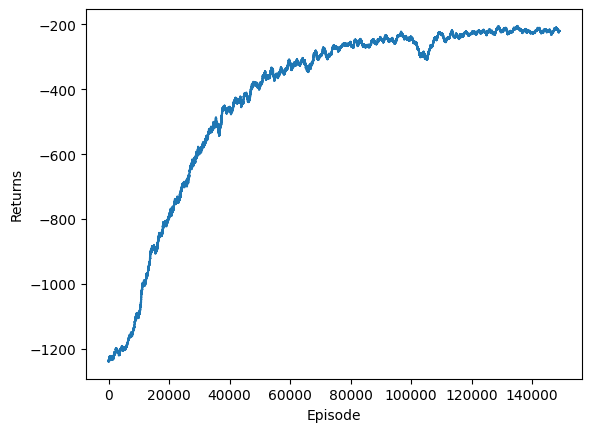

In [15]:
def running_mean(x, N=1000):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(returns))
plt.xlabel('Episode')
plt.ylabel('Returns')

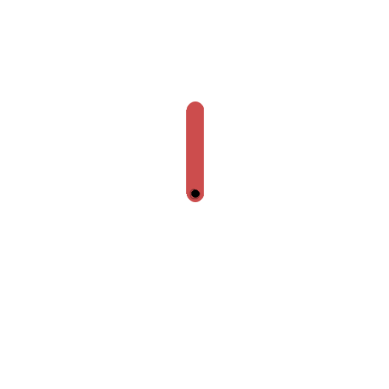

-2.8494814076334647


In [18]:
state, info = env.reset()
render_frame(env)
done = False

r = 0
while not done:

    discrete_state = get_discrete_state(state)
    action = np.argmax(q_table[discrete_state])

    # apply the action to the environment
    torque = action_space[action]
    state, reward, done, truncated, _ = env.step(torque)
    done = done or truncated
    render_frame(env)
    r += reward

print(r)